# MNIST subset with vanilla network

For DL, I get about what a RF (500 trees) gets with 8k training / 2k validation subsample of 60k images.

**colab** github can't seem to display notebooks so...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/mnist/notebooks/mnist-vanilla.ipynb)


## Setup
Make sure to enable this to see progress bars:

```
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [1]:
!pip install -q --no-deps tensorflow-addons~=0.7
!pip install -q "tqdm>=4.36.1"

## MNIST Images

In [2]:
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
# put back together so we can take our own subset
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
n, w, h = X.shape

### Make sure to shuffle

Shuffle before getting subsample or else we get mostly 0s,1s,2s etc...

In [4]:
subset = 10_000
idx = np.random.randint(0,n,size=subset)
X = X[idx,:,:]
y = y[idx]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n, w, h = X_train.shape

print(f"Using {n} images")

Using 8000 images


## RandomForestClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [15]:
rf = RandomForestClassifier(n_estimators=500,
                            min_samples_leaf=1,
                            oob_score=True, n_jobs=-1)
rf.fit(X_train.reshape(-1,w*h), y_train)
print("OOB", rf.oob_score_)

y_pred = rf.predict(X_test.reshape(-1, w*h))
conf = confusion_matrix(y_test, y_pred)
print(conf)
print("test accuracy", accuracy_score(y_test, y_pred))

OOB 0.952625
[[214   0   1   0   0   0   0   0   0   0]
 [  0 230   2   1   0   1   1   0   0   0]
 [  3   0 187   0   1   0   1   1   1   1]
 [  0   1   5 191   0   3   0   1   2   1]
 [  0   1   0   0 190   0   0   0   2   3]
 [  2   0   0   3   0 159   2   0   0   2]
 [  0   0   0   0   1   0 162   0   0   0]
 [  0   1   3   0   0   0   0 204   1   1]
 [  0   3   2   3   2   2   1   0 182   7]
 [  2   0   2   3   4   0   0   2   3 196]]
test accuracy 0.9575


Conclusion is that a RF with only 500 trees does a quick easy job on this 8k image subsample. Does about what DL does with vanilla net. About 95% accurate.

## Vanilla two-layers of 512 neurons, softmax on end

In [8]:
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback

### Don't forget to normalize data for DL

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [10]:
num_classes = 10
layer1 = 512
layer2 = 512
batch_size = 2000
dropout = 0.2

model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=w*h, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(layer2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(num_classes, activation='softmax'))

In [11]:
# learning_rate = 0.15
# opt = optimizers.Adam(lr=learning_rate)
opt = optimizers.RMSprop() # this one seems a bit better

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

# callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train.reshape(n,w*h), y_train,
                    shuffle=True,
                    epochs=200,
                    validation_data=(X_test.reshape(-1,w*h), y_test),
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

In [12]:
y_pred = model.predict(X_test.reshape(-1,w*h))
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y_test, y_pred)
print("Keras validation accuracy", val_accur)

conf = confusion_matrix(y_test, y_pred)
print(conf)

Keras validation accuracy 0.956
[[209   0   0   0   0   1   0   0   3   2]
 [  0 232   1   0   0   0   0   0   2   0]
 [  0   0 185   1   0   0   0   2   5   2]
 [  0   1   2 189   0   4   0   2   3   3]
 [  0   2   1   1 178   0   1   2   1  10]
 [  1   0   0   0   0 157   0   0   5   5]
 [  2   2   0   0   1   1 157   0   0   0]
 [  0   2   0   0   0   0   0 202   1   5]
 [  0   1   1   1   0   1   0   0 195   3]
 [  1   0   0   0   0   1   0   1   1 208]]


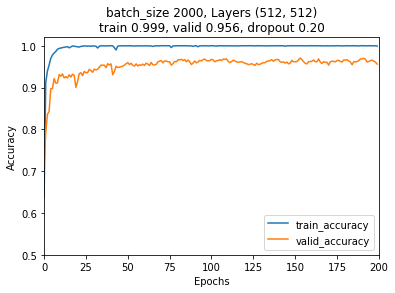

In [13]:
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
plt.title(f"batch_size {batch_size}, Layers {layer1,layer2}\ntrain {accur[-1]:.3f}, valid {val_accur[-1]:.3f}, dropout {dropout:.2f}")
plt.xlim(0, 200)
plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()

## Effect of data set size

With 1k not 10k records, RF and DL also seemed about the same with DL again a little ahead of RF, though slower and requiring more expertise to train.  Accur dropped from .95ish to .86ish so more training data helped both.